# Estimating Spatially Varying Heat Transfer Coefficients Using Ensemble Smoothers

Imagine you're an archaeologist who has discovered a large, ancient metal plate buried in your garden.\
You're intrigued by its thermal properties, particularly how well it transfers heat, as this could provide clues about its composition and origin.\
Using a metal detector you've established the size and have concluded that it is too large to excavate without risking damage.\
Instead, you drill a few small holes at specific locations and measure the heat transfer coefficient at these points.\
The sparse measurements show that the plates' heat transfer coefficient varies in space, but you need to know it everywhere.\
To gather more information, you decide to introduce a heat source by drilling a hole and lowering a heat element to warm up the plate at that point.\
After removing the heat source, the plate will cool down according to the heat equation from physics.\
Using the sparse measurements and the observed cooling behavior, your goal is to estimate the heat transfer coefficient everywhere on the plate.


In [1]:
import numpy as np
import pandas as pd

np.set_printoptions(suppress=True)
# Relatively easy to find good solution
rng = np.random.default_rng(1234)
# More difficult
# rng = np.random.default_rng(100)

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams.update({"font.size": 10})
# Ignore error when drawing many figures
plt.rcParams.update({"figure.max_open_warning": 0})
from ipywidgets import interact
import ipywidgets as widgets

from p_tqdm import p_map

In [2]:
%load_ext autoreload
%autoreload 2
from dass import pde, utils, analysis, taper, geostat

## Define ensemble size and parameters related to the simulator

In [3]:
# Defines how many simulations to run
N = 50

# Number of grid-cells in x and y direction
nx = 10

# time steps
k_start = 0
k_end = 500

## Define and visualize the `prior` parameter ensemble

The Ensemble Smoother searches for solutions in `Ensemble Subspace`, which means that it tries to find a linear combination of the priors that best fit the observed data.
A good prior is therefore vital.

Since the prior depends on the random seed, some priors will lead to responses that are more difficult to work with than others.

In [4]:
def sample_prior_conductivity(N):
    mesh = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, nx))
    return np.exp(geostat.gaussian_fields(mesh, rng, N, r=0.8))


# Evensens' formulation of the Ensemble Smoother has the prior as
# a (nx * nx, N) matrix, i.e (number of parameters, N).
A = sample_prior_conductivity(N).T

# We'll also need a list of matrices to run simulations in parallel later on.
# A list is also a bit easier to interactively visualize.
alphas = []
for j in range(N):
    alphas.append(A[:, j].reshape(nx, nx))

In [5]:
def interactive_prior_fields(n):
    fig, ax = plt.subplots()
    ax.set_title(f"Prior parameter field {n}")
    p = ax.pcolormesh(alphas[n].T)
    utils.colorbar(p)
    fig.tight_layout()


interact(
    interactive_prior_fields,
    n=widgets.IntSlider(min=0, max=N - 1, step=1, value=0),
)

interactive(children=(IntSlider(value=0, description='n', max=49), Output()), _dom_classes=('widget-interact',…

<function __main__.interactive_prior_fields(n)>

## Define true parameters, set true initial conditions and calculate the true temperature field

In real problems, these true parameter values are not known.
They are in fact what we are trying to estimate.
However, in this synthetic example we know everything which makes it much easier to judge whether an algorithm works or not.

In [6]:
# Set the coefficient of heat transfer for each grid cell.
# alpha_t = sample_prior_conductivity(1).T.reshape(nx, nx)
# Let's use as true parameter field one relization from the prior
# to make it easier for the Ensemble Smoother to find the solution.
alpha_t = alphas[0]

# Resolution in the x-direction (nothing to worry about really)
dx = 1

# Calculate maximum `dt`.
# If higher values are used, the numerical solution will become unstable.
# Note that this could be avoided if we used an implicit solver.
dt = dx**2 / (4 * max(np.max(A), np.max(alpha_t)))

# Define initial condition, i.e., the initial temperature distribution.
# How you define initial conditions will effect the spread of results,
# i.e., how similar different realisations are.
u0 = np.zeros((nx, nx))
u0[5:7, 5:7] = 100

# How much noise to add to heat equation, also called model noise.
# scale = 0.1
scale = None
num_steps = k_end - k_start

u_t = pde.heat_equation(u0, alpha_t, dx, dt, num_steps, rng=rng, scale=scale)

## Plot every cells' heat transfer coefficient, i.e., the parameter field

Again, this is what we are trying estimate.

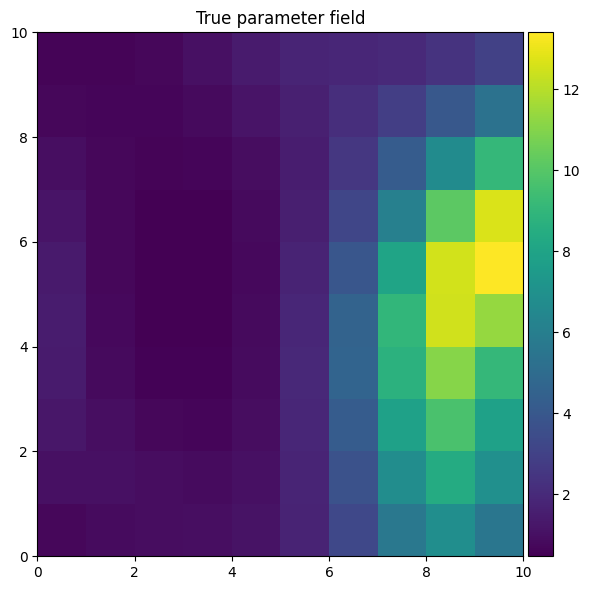

In [7]:
fig, ax = plt.subplots()
ax.set_title("True parameter field")
p = ax.pcolormesh(alpha_t.T)
utils.colorbar(p)
fig.tight_layout()

## Interactive plot of true temperature field

Shows how the temperature of the true field changes with time.

In [8]:
def interactive_truth(k):
    fig, ax = plt.subplots()
    fig.suptitle("True temperature field")
    p = ax.pcolormesh(u_t[k].T, cmap=plt.cm.jet, vmin=0, vmax=100)
    ax.set_title(f"k = {k}")
    utils.colorbar(p)
    fig.tight_layout()


interact(
    interactive_truth,
    k=widgets.IntSlider(min=k_start, max=k_end - 1, step=1, value=0),
)

interactive(children=(IntSlider(value=0, description='k', max=499), Output()), _dom_classes=('widget-interact'…

<function __main__.interactive_truth(k)>

## Define placement of sensors and generate synthetic observations based on the true temperature field

In [9]:
# We'll place the sensors close to heat-sources because the plate cools of quite quickly.
obs_coordinates = [
    utils.Coordinate(5, 3),
    utils.Coordinate(3, 5),
    utils.Coordinate(5, 7),
    utils.Coordinate(7, 5),
    utils.Coordinate(2, 2),
    utils.Coordinate(7, 2),
]

# Random placement of sensors
# Try adding a lot of sensors to see how the fit changes.
# As a side-note, in a reservoir setting, we might drill horizontal wells so sensors
# may in fact be placed quite far away from whever we started drilling a production well.
# pad = 1
# coords = np.array([(x, y) for x in range(pad, nx - pad) for y in range(pad, nx - pad)])
# ncoords = coords.shape[0]
# nmeas = 10
# coords_idx = np.random.choice(np.arange(ncoords), size=nmeas, replace=False)
# obs_coordinates = [utils.Coordinate(xc, yc) for xc, yc in coords[coords_idx]]

# At which times observations are taken
obs_times = np.linspace(5, k_end, 8, endpoint=False, dtype=int)

d = utils.observations(obs_coordinates, obs_times, u_t, lambda value: abs(0.05 * value))
m = d.shape[0]
print("Number of observations: ", m)

Number of observations:  48


# Plot temperature field at a specific time and show placement of sensors

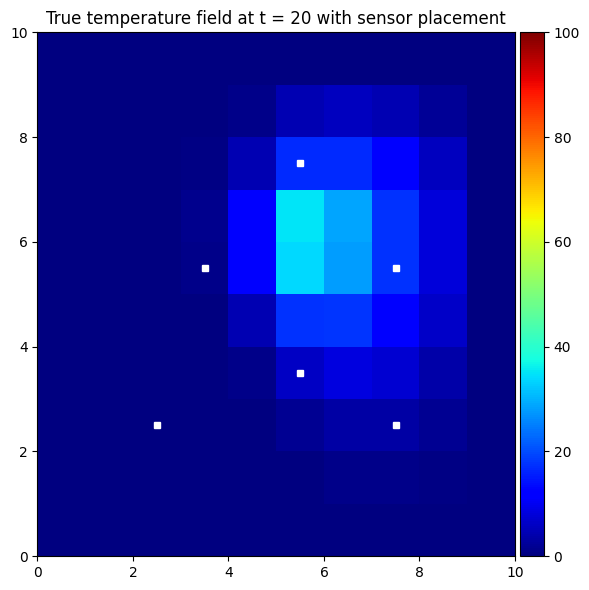

In [10]:
k_levels = d.index.get_level_values("k").to_list()
x_levels = d.index.get_level_values("x").to_list()
y_levels = d.index.get_level_values("y").to_list()

obs_coordinates_from_index = set(zip(x_levels, y_levels))
x, y = zip(*obs_coordinates_from_index)

fig, ax = plt.subplots()
time_to_plot_at = 20
p = ax.pcolormesh(u_t[time_to_plot_at].T, cmap=plt.cm.jet, vmin=0, vmax=100)
ax.set_title(f"True temperature field at t = {time_to_plot_at} with sensor placement")
utils.colorbar(p)
ax.plot([i + 0.5 for i in x], [j + 0.5 for j in y], "s", color="white", markersize=5)
fig.tight_layout()

# Running `N` simulations in parallel

The term `forward model` is often used to mean a simulator (like our 2D heat-equation solver) in addition to pre-, and post-processing steps.

## Define random seeds in a way suitable for multiprocessing

You can read up on why this is necessary here:

https://numpy.org/doc/stable/reference/random/parallel.html#seedsequence-spawning

In [11]:
ss = np.random.SeedSequence(12345)
child_seeds = ss.spawn(N)
streams = [np.random.default_rng(s) for s in child_seeds]

In [12]:
fwd_runs = p_map(
    pde.heat_equation,
    [u0] * N,
    alphas,
    [dx] * N,
    [dt] * N,
    [num_steps] * N,
    streams,
    [scale] * N,
    desc=f"Running forward model.",
)

Running forward model.:   0%|          | 0/50 [00:00<?, ?it/s]

## Interactive plot of single realisations

Note that every realization has the same initial temperature field at time-step `k=0`, but that each realization cools down a bit differently because the plate in each realization has somewhat different material properties.

In [13]:
def interactive_realisations(k, n):
    fig, ax = plt.subplots()
    fig.suptitle(f"Temperature field for realisation {n}")
    p = ax.pcolormesh(fwd_runs[n][k].T, cmap=plt.cm.jet, vmin=0, vmax=100)
    ax.set_title(f"k = {k}")
    ax.plot(
        [i + 0.5 for i in x], [j + 0.5 for j in y], "s", color="white", markersize=5
    )
    utils.colorbar(p)
    fig.tight_layout()


interact(
    interactive_realisations,
    k=widgets.IntSlider(min=k_start, max=k_end - 1, step=1, value=0),
    n=widgets.IntSlider(min=0, max=N - 1, step=1, value=0),
)

interactive(children=(IntSlider(value=0, description='k', max=499), IntSlider(value=0, description='n', max=49…

<function __main__.interactive_realisations(k, n)>

# Ensemble Smoother (ES)

## Measure model response at points in time and space where we have observations

The `Ensemble Smoother` uses the difference between what the simulator claims happened at `(k, x, y)` and what uncertain sensors claim happened at the same point in time and space.
Hence, we only need the responses where we have actual observations.

In [14]:
Y_df = pd.DataFrame({"k": k_levels, "x": x_levels, "y": y_levels})

for real, fwd_run in enumerate(fwd_runs):
    Y_df = Y_df.assign(**{f"R{real}": fwd_run[k_levels, x_levels, y_levels]})

Y_df = Y_df.set_index(["k", "x", "y"], verify_integrity=True)

Y = Y_df.values

assert Y.shape == (
    m,
    N,
), "Measured responses must be a matrix with dimensions (number of observations x number of realisations)"

## Checking `Coverage`

Ideally, we want our model to be so good that its responses do not deviate much from what our sensors are telling us.
When this is the case, we say that we have achieved good `coverage`.

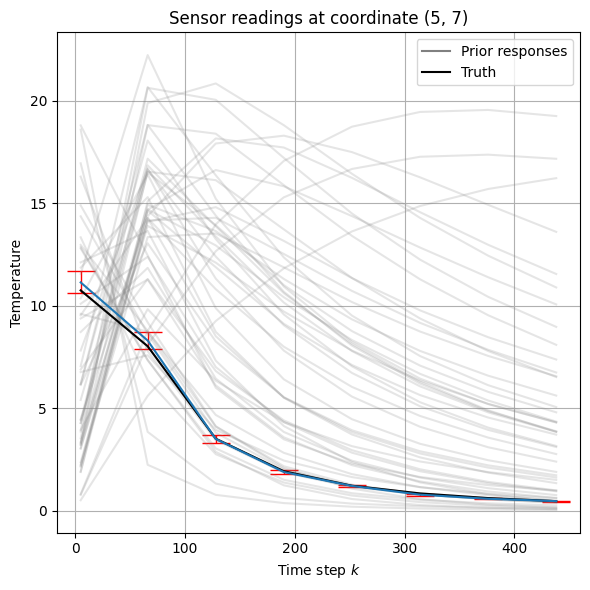

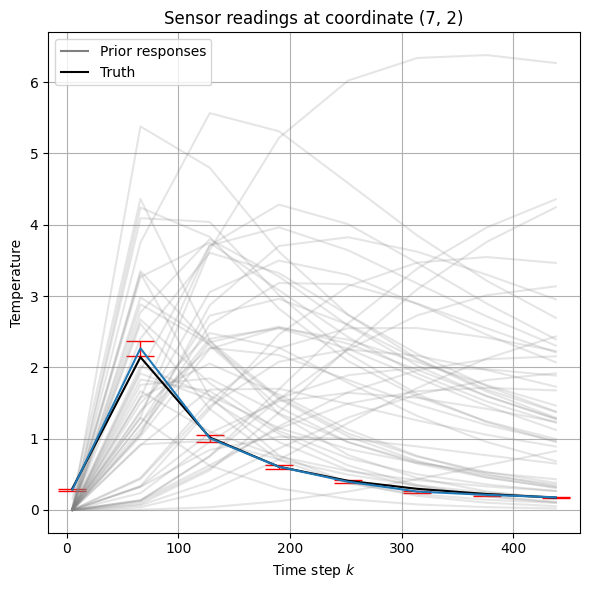

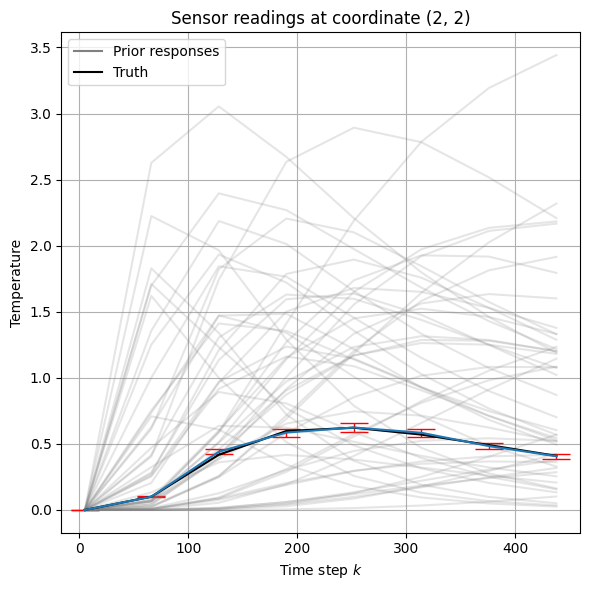

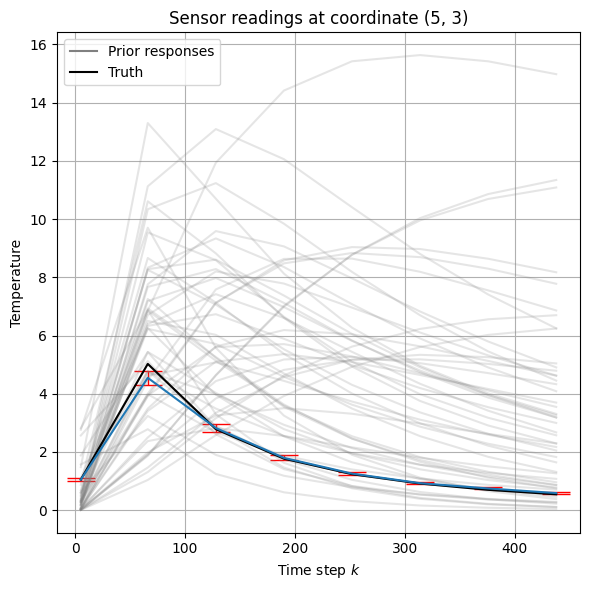

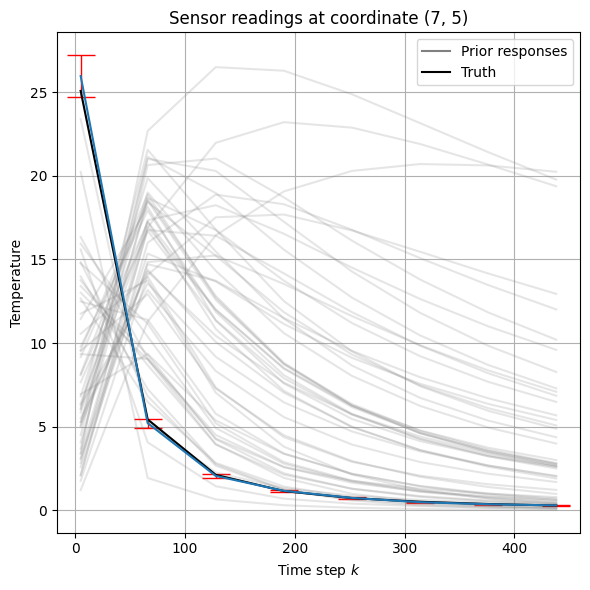

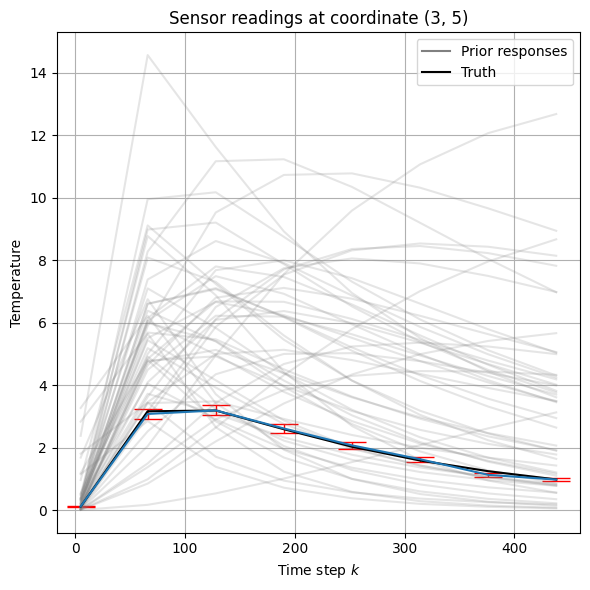

In [15]:
def plot_responses(
    time_steps,
    observations,
    responses_ensemble,
    response_truth,
    responses_ensemble_post=None,
):
    x_levels = observations.index.get_level_values("x").to_list()
    y_levels = observations.index.get_level_values("y").to_list()

    obs_coordinates = set(zip(x_levels, y_levels))

    for x, y in obs_coordinates_from_index:
        fig, ax = plt.subplots()
        ax.set_title(f"Sensor readings at coordinate {x, y}")
        ax.set_ylabel("Temperature")
        ax.set_xlabel("Time step $k$")
        ax.grid()

        df_single_sensor = observations.query(f"x=={x} & y=={y}")

        y_sensor = df_single_sensor["value"]
        yerr_sensor = df_single_sensor["sd"]

        ax.errorbar(
            time_steps,
            y_sensor,
            yerr_sensor,
            ecolor="red",
            capsize=10,
            elinewidth=1,
            markeredgewidth=1,
        )

        ax.plot(
            time_steps,
            responses_ensemble.query(f"x=={x} & y=={y}"),
            color="gray",
            alpha=0.2,
            label="_nolegend_",
        )
        ax.plot([], [], "gray", label="Prior responses")

        ax.plot(
            time_steps, response_truth[time_steps, x, y], color="black", label="Truth"
        )

        if responses_ensemble_post is not None:
            ax.plot(
                time_steps,
                responses_ensemble_post.query(f"x=={x} & y=={y}"),
                color="orange",
                alpha=0.2,
            )
            ax.plot([], [], "orange", label="Posterior responses")

        ax.legend(loc="best")

        fig.tight_layout()


plot_responses(np.unique(k_levels), d, Y_df, u_t)

## Ensemble representation for measurements (Section 9.4 of [1])

Note that Evensen calls measurements what ERT calls observations.

In [16]:
# Assume diagonal ensemble covariance matrix for the measurement perturbations.
# Is this a big assumption?
Cdd = np.diag(d.sd.values**2)

# 9.4 Ensemble representation for measurements
E = rng.multivariate_normal(mean=np.zeros(len(Cdd)), cov=Cdd, size=N).T
E = E - E.mean(axis=1, keepdims=True)
assert E.shape == (m, N)

# We will not use the sample covariance Cee, and instead use Cdd directly.
# It is not clear to us why Cee is proposed used.
# Cee = (E @ E.T) / (N - 1)

D = np.ones((m, N)) * d.value.values.reshape(-1, 1) + E

## Deactivate sensors that measure the same temperature in all realizations

This means that the temperature did not change at that sensor location.
Including these will lead to numerical issues.

In [17]:
enough_ens_var_idx = Y.var(axis=1) > 1e-6

print(
    f"{list(enough_ens_var_idx).count(False)} measurements will be deactivated because of ensemble collapse"
)
Y = Y[enough_ens_var_idx, :]
D = D[enough_ens_var_idx, :]
Cdd = Cdd[enough_ens_var_idx, :]
Cdd = Cdd[:, enough_ens_var_idx]

1 measurements will be deactivated because of ensemble collapse


## Deactivate responses that are too far away from observations

In [18]:
ens_std = Y.std(axis=1)
ens_mean = Y.mean(axis=1)
obs_std = d.sd.values[enough_ens_var_idx]
obs_value = d.value.values[enough_ens_var_idx]
innov = obs_value - ens_mean

is_outlier = np.abs(innov) > 3.0 * (ens_std + obs_std)

print(
    f"{list(is_outlier).count(True)} out of {Y.shape[0]} measurements will be deactivated because they are outliers"
)
Y = Y[~is_outlier, :]
D = D[~is_outlier, :]
Cdd = Cdd[~is_outlier, :]
Cdd = Cdd[:, ~is_outlier]

1 out of 47 measurements will be deactivated because they are outliers


## Adaptive localization

Localization with correlation used as distance.

In [19]:
Y_prime = Y - Y.mean(axis=1, keepdims=True)
C_YY = Y_prime @ Y_prime.T / (N - 1)
Sigma_Y = np.diag(np.sqrt(np.diag(C_YY)))
corr_trunc = 3 / np.sqrt(N)

A_ES_loc = []

for A_chunk in np.array_split(A, indices_or_sections=10):
    A_prime = A_chunk - A_chunk.mean(axis=1, keepdims=True)
    C_AA = A_prime @ A_prime.T / (N - 1)

    # State-measurement covariance matrix
    C_AY = A_prime @ Y_prime.T / (N - 1)
    Sigma_A = np.diag(np.sqrt(np.diag(C_AA)))

    # State-measurement correlation matrix
    c_AY = np.linalg.inv(Sigma_A) @ C_AY @ np.linalg.inv(Sigma_Y)

    _, corr_idx_Y = np.where(np.triu(np.abs(c_AY)) > corr_trunc)
    corr_idx_Y = np.unique(corr_idx_Y)

    Y_loc = Y[corr_idx_Y, :]
    D_loc = D[corr_idx_Y, :]
    Cdd_loc = Cdd[corr_idx_Y, :]
    Cdd_loc = Cdd_loc[:, corr_idx_Y]

    X_loc = analysis.ES(Y_loc, D_loc, Cdd_loc)
    A_ES_loc.append(A_chunk @ X_loc)

A_ES_loc = np.vstack(A_ES_loc)
A_ES_loc = A_ES_loc.clip(min=1e-8)

## Perform ES update

In [20]:
X = analysis.ES(Y, D, Cdd)
A_ES = A @ X

In [21]:
# Sanity check as the results should be the same
# with and without localization when correlation truncation is set to zero.
if corr_trunc == 0.0:
    assert np.isclose(A_ES, A_ES_loc, atol=1e-5).all()

In [22]:
# The update may give non-physical parameter values, which here means negative heat conductivity.
# Setting negative values to a small positive value but not zero because we want to be able to divide by them.
A_ES = A_ES.clip(min=1e-8)

## Numerical comparison of prior and posterior using RMSE

The posterior calculated by ES is on average expected to be closer to the truth than the prior.
By "closer", we mean in terms of Root Mean Squared Error (RMSE).
The reason for this is that ES is based on the Kalman Filter, which is the "Best Linear Unbiased Estimator" (BLUE) and BLUE estimators have this property.
However, this holds for certain only when the number of realizations tends to infinity.
In practice this mean that we might end up with an increased RMSE when using a finite number of realizations.

In [23]:
err_posterior = alpha_t.ravel() - A_ES.mean(axis=1)
np.sqrt(np.mean(err_posterior * err_posterior))

1.4399646919149367

In [24]:
err_posterior_loc = alpha_t.ravel() - A_ES_loc.mean(axis=1)
np.sqrt(np.mean(err_posterior_loc * err_posterior_loc))

1.5160179602191155

In [25]:
err_prior = alpha_t.ravel() - A.mean(axis=1)
np.sqrt(np.mean(err_prior * err_prior))

3.7960509770997004

## Graphical comparison of prior and posterior mean-fields

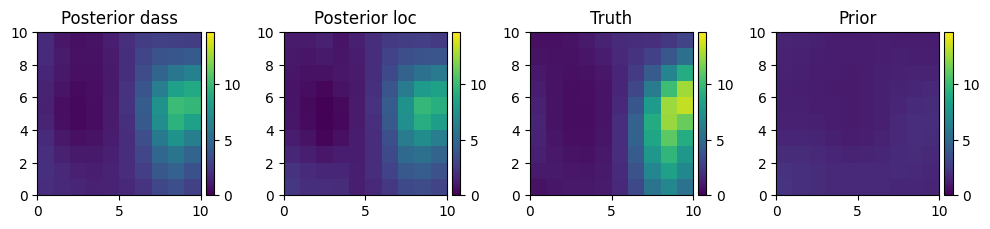

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(10, 10)

ax[0].set_title(f"Posterior dass")
ax[1].set_title(f"Posterior loc")
ax[2].set_title(f"Truth")
ax[3].set_title(f"Prior")

vmin = 0
vmax = np.max(alpha_t) + 0.1 * np.max(alpha_t)
p0 = ax[0].pcolormesh(A_ES.mean(axis=1).reshape(nx, nx).T, vmin=vmin, vmax=vmax)
p1 = ax[1].pcolormesh(A_ES_loc.mean(axis=1).reshape(nx, nx).T, vmin=vmin, vmax=vmax)
p2 = ax[2].pcolormesh(alpha_t.T, vmin=vmin, vmax=vmax)
p3 = ax[3].pcolormesh(A.mean(axis=1).reshape(nx, nx).T, vmin=vmin, vmax=vmax)

utils.colorbar(p0)
utils.colorbar(p1)
utils.colorbar(p2)
utils.colorbar(p3)

ax[0].set_aspect("equal", "box")
ax[1].set_aspect("equal", "box")
ax[2].set_aspect("equal", "box")
ax[3].set_aspect("equal", "box")

fig.tight_layout()

## Plot standard deviations of fields to see which grid cells were updated the most

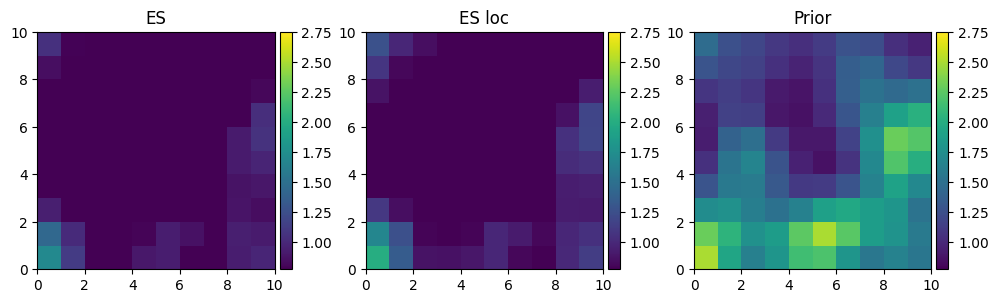

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(10, 10)

ax[0].set_title(f"ES")
ax[1].set_title(f"ES loc")
ax[2].set_title(f"Prior")

vmin = A.std(axis=1).min() - 0.1 * A.std(axis=1).min()
vmax = A.std(axis=1).max() + 0.1 * A.std(axis=1).max()
p0 = ax[0].pcolormesh(A_ES.std(axis=1).reshape(nx, nx).T, vmin=vmin, vmax=vmax)
p1 = ax[1].pcolormesh(A_ES_loc.std(axis=1).reshape(nx, nx).T, vmin=vmin, vmax=vmax)
p2 = ax[2].pcolormesh(A.std(axis=1).reshape(nx, nx).T, vmin=vmin, vmax=vmax)

utils.colorbar(p0)
utils.colorbar(p1)
utils.colorbar(p2)

ax[0].set_aspect("equal", "box")
ax[1].set_aspect("equal", "box")
ax[2].set_aspect("equal", "box")

fig.tight_layout()

## Investigate quality of history match

Running forward model.:   0%|          | 0/50 [00:00<?, ?it/s]

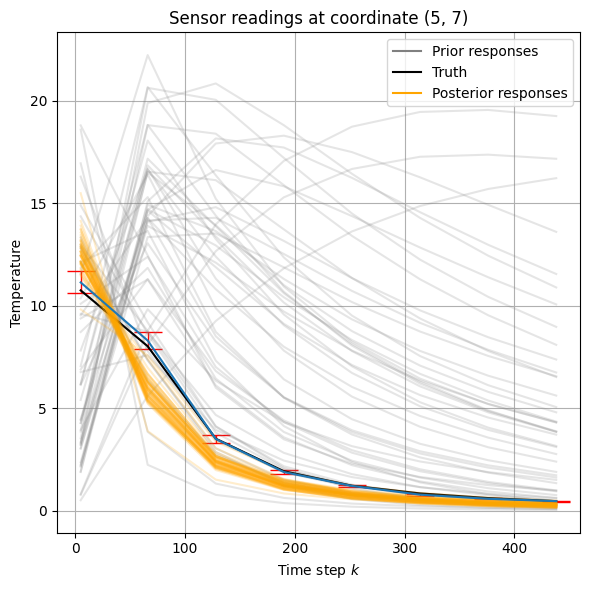

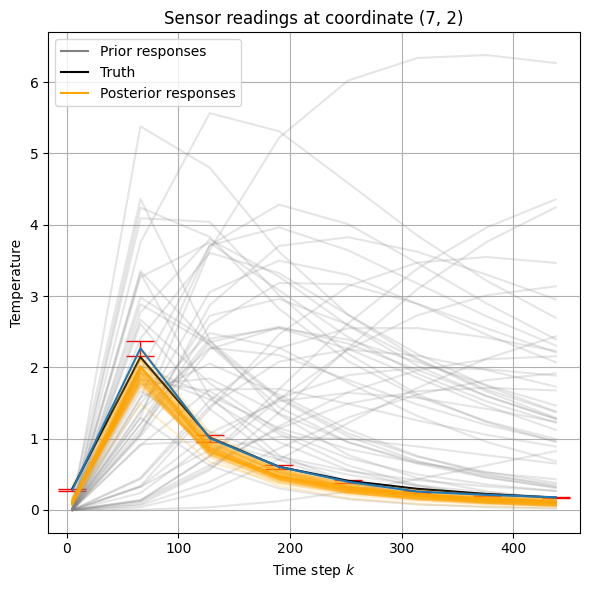

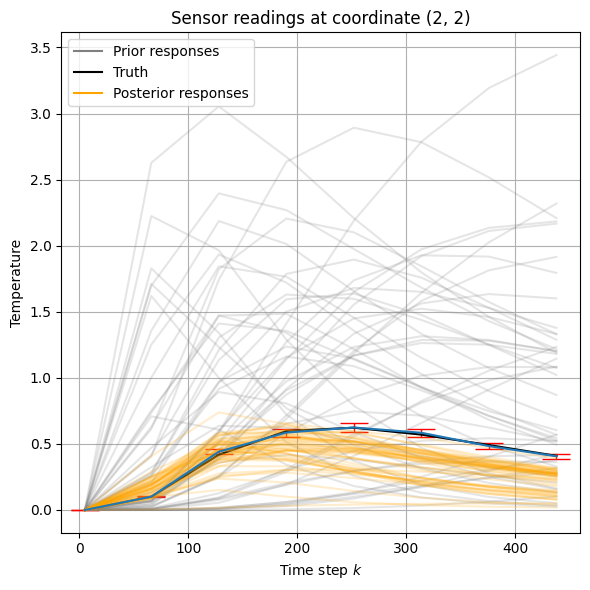

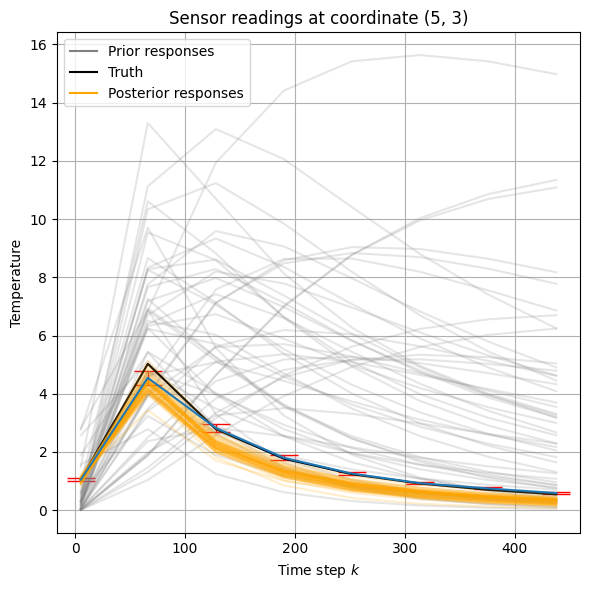

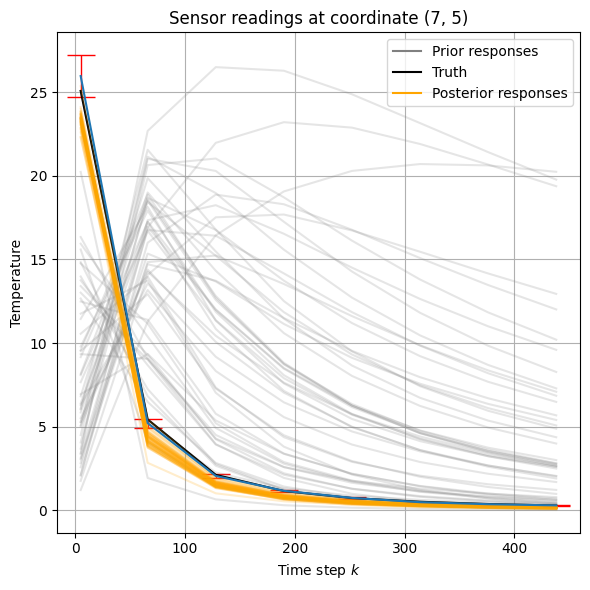

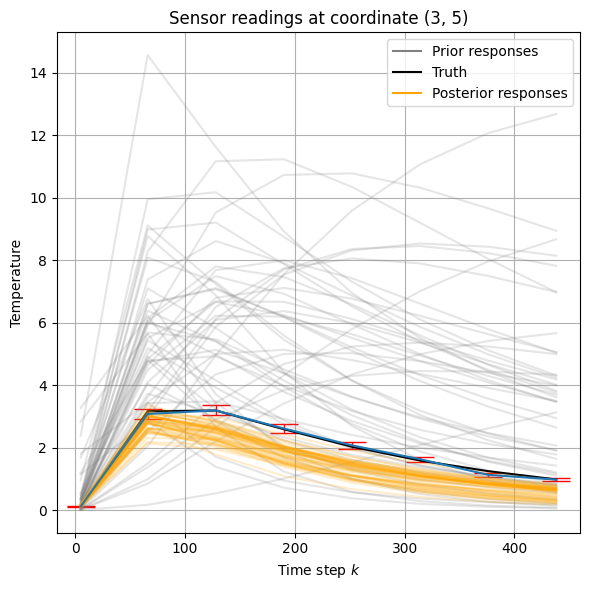

In [28]:
alphas_post = []
for realization in range(A_ES.shape[1]):
    alphas_post.append(A_ES[:, realization].reshape(nx, nx))

# Define initial condition and number of steps
u0 = np.zeros((nx, nx))
u0[5:7, 5:7] = 100
num_steps = k_end - k_start

fwd_runs = p_map(
    pde.heat_equation,
    [u0] * N,
    alphas_post,
    [dx] * N,
    [dt] * N,
    [num_steps] * N,
    streams,
    [scale] * N,
    desc=f"Running forward model.",
)

Y_df_post = pd.DataFrame({"k": k_levels, "x": x_levels, "y": y_levels})
for real, fwd_run in enumerate(fwd_runs):
    Y_df_post = Y_df_post.assign(**{f"R{real}": fwd_run[k_levels, x_levels, y_levels]})
Y_df_post = Y_df_post.set_index(["k", "x", "y"], verify_integrity=True)
plot_responses(np.unique(k_levels), d, Y_df, u_t, Y_df_post)